In [63]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Step 1: Read the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fiverr/Lukas B/last_quantity_sold.csv')

In [32]:
data

,DATE,Quantity
0,1/2/2020,2471.6130
1,1/3/2020,6953.5582
2,1/4/2020,49.3800
3,1/6/2020,30606.2143
4,1/7/2020,38250.7541
...,...,...
1423,3/10/2024,3035.1000
1424,3/11/2024,53885.3590
1425,3/12/2024,48295.1650
1426,3/13/2024,48084.9700


# Weekly data variation (pattern)

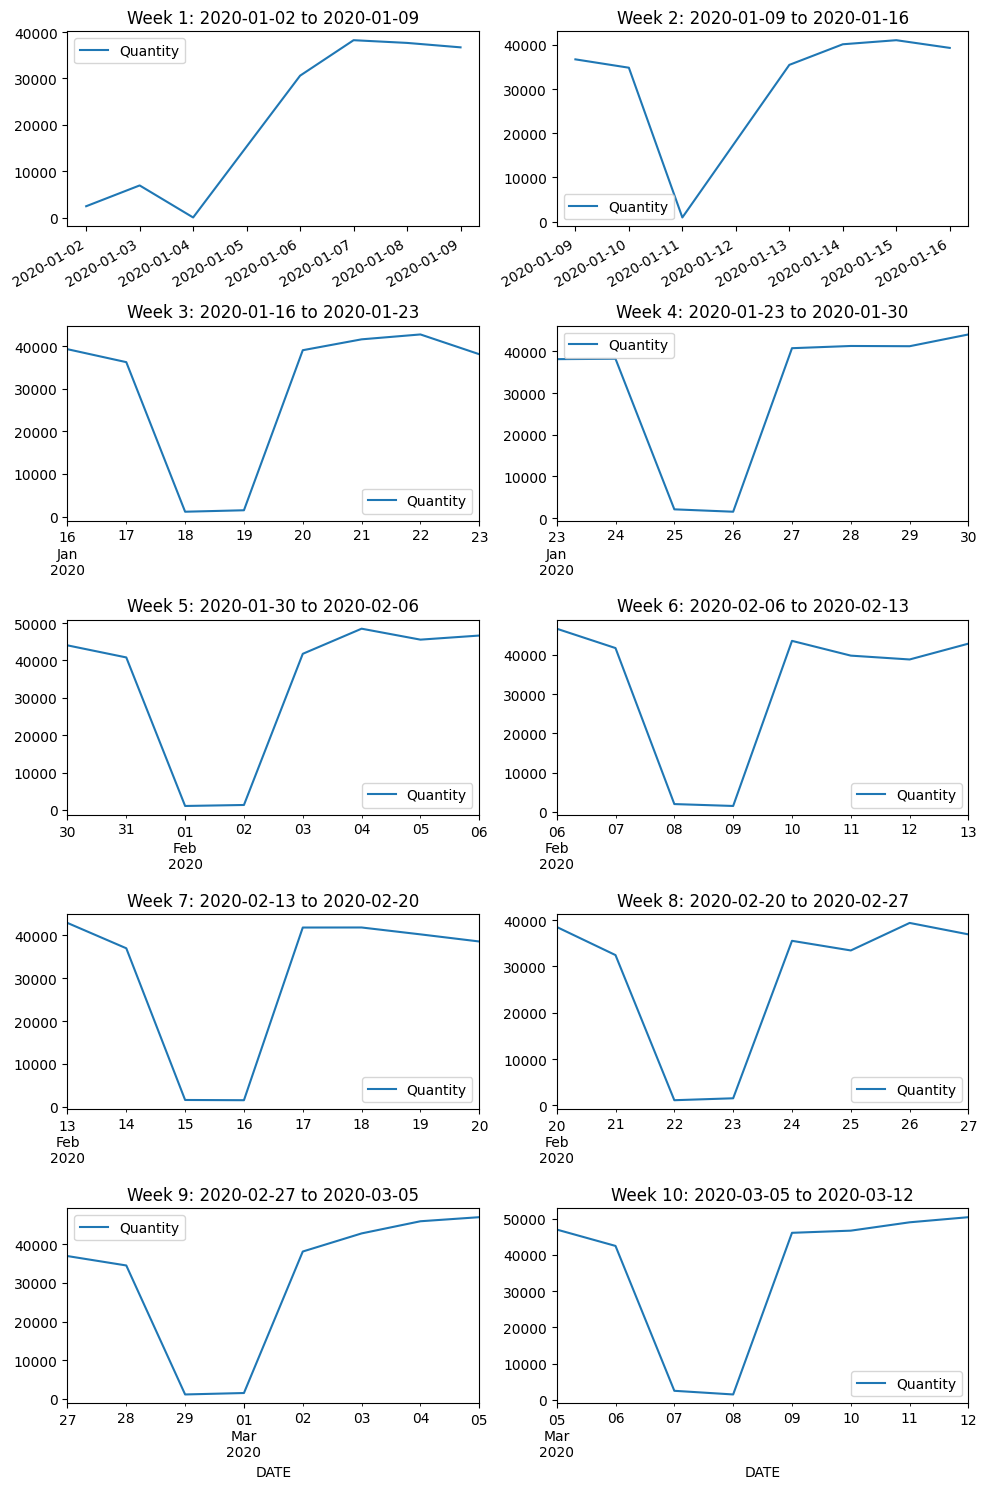

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

# Define the start date
start_date = pd.to_datetime('2020-01-02')

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    # Calculate the start and end dates for each week
    week_start = start_date + pd.DateOffset(weeks=i)
    week_end = week_start + pd.DateOffset(weeks=1)

    # Filter the data for the current week
    week_data = data[data['DATE'].between(week_start, week_end)]

    # Plot the data for the current week
    week_data.plot(x='DATE', y='Quantity', ax=ax)

    # Set title for the subplot
    ax.set_title(f'Week {i+1}: {week_start.strftime("%Y-%m-%d")} to {week_end.strftime("%Y-%m-%d")}')

    # Remove x-axis label for all but the last row of subplots
    if i < 8:
        ax.set_xlabel('')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## The above plots shows there is clearly a weekly pattern. In the middle of week there is a significant drop at every week

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      1428 non-null   object 
 1   Quantity  1428 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.4+ KB


In [39]:
# Step 3: Split data into train and test sets
train_size = int(len(data) * 0.8)  # 80% train, 20% test
train, test = data.iloc[:train_size], data.iloc[train_size:]

# ExponentialSmoothing

In [45]:
# Step 4: Train the Holt-Winters model
model = ExponentialSmoothing(train['Quantity'], seasonal='add', seasonal_periods=7).fit()

# Step 5: Make predictions
predictions = model.forecast(len(test) + 30)  # Forecast for test set + future 30 days

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


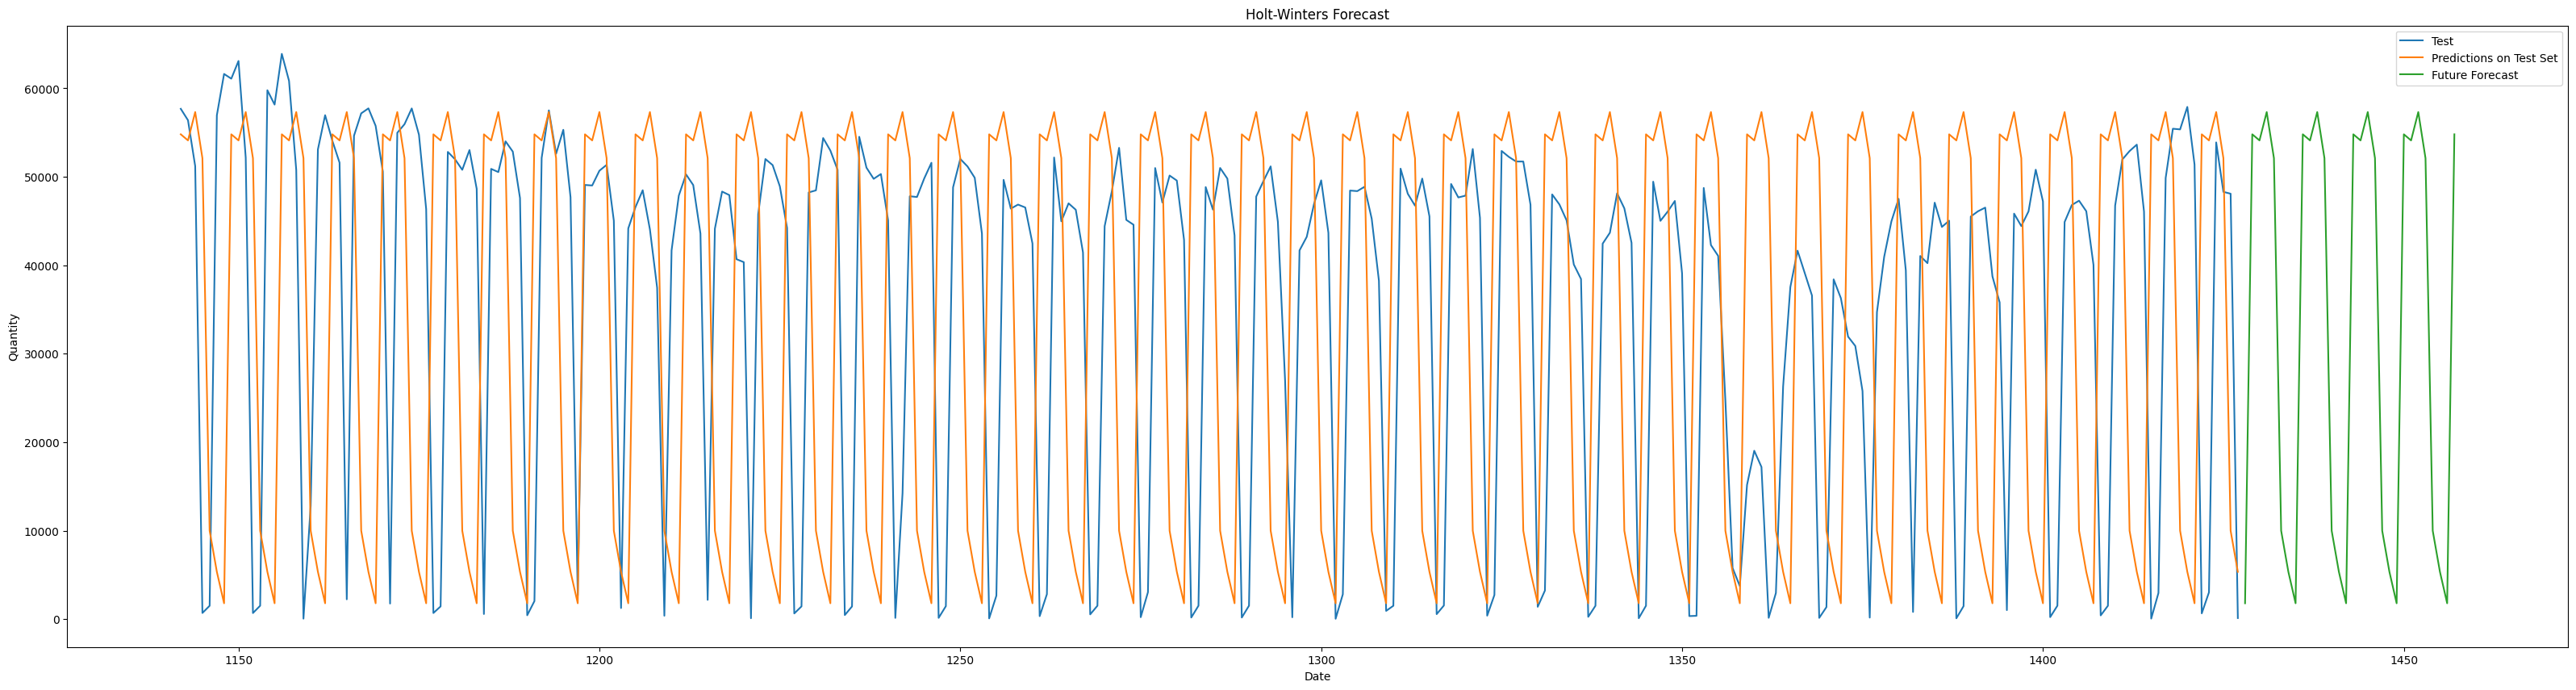

In [46]:
# Step 6: Visualize the results
plt.figure(figsize=(40, 10))
# plt.plot(train['Quantity'], label='Train')
plt.plot(test['Quantity'], label='Test')
plt.plot(predictions[:len(test)], label='Predictions on Test Set')
plt.plot(predictions[len(test):], label='Future Forecast')
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

## The seasonal pattern is weekly here. So future forecast reflects this weekly pattern successfully

# LSTM

Epoch 1/100
36/36 [==============================] - 2s 18ms/step - loss: 0.1870 - val_loss: 0.1031
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1099 - val_loss: 0.0895
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0934 - val_loss: 0.0694
Epoch 4/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0696 - val_loss: 0.0514
Epoch 5/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0558 - val_loss: 0.0484
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0490 - val_loss: 0.0437
Epoch 7/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.0424
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0427 - val_loss: 0.0418
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0424 - val_loss: 0.0412
Epoch 10/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0406 - val_loss: 0.0405
Epoch 1

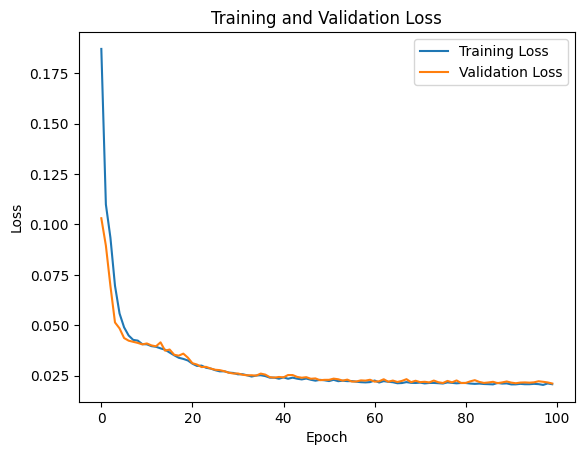

9/9 [==============================] - 0s 3ms/step


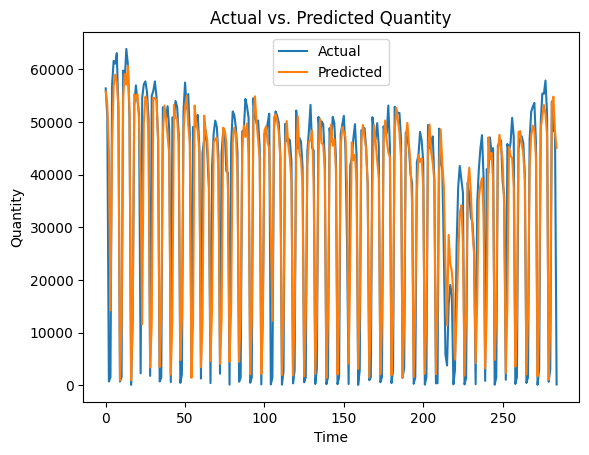

In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Convert 'DATE' column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Sort the dataframe by date
data.sort_values(by='DATE', inplace=True)

# Extract 'Quantity' values
quantity_data = data['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
quantity_data_scaled = scaler.fit_transform(quantity_data)

# Define function to create input sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps to look back)
sequence_length = 7  # One week

# Create input sequences and labels
X, y = create_sequences(quantity_data_scaled, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot actual vs. predicted values
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs. Predicted Quantity')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.legend()
plt.show()


In [81]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for actual and predicted values
fig.add_trace(go.Scatter(x=data.index[train_size:], y=y_test_inv.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=data.index[train_size:], y=y_pred_inv.flatten(), mode='lines', name='Predicted'))

# Update layout
fig.update_layout(
    title='Actual vs. Predicted Quantity',
    xaxis_title='Time',
    yaxis_title='Quantity',
    width=1000,  # Adjust the width as needed
    height=500,  # Adjust the height as needed
)

# Show the plot
fig.show()


In [67]:
# Get the last sequence from the data
last_sequence = quantity_data_scaled[-sequence_length:]

# Reshape the last sequence to match the input shape of the model
last_sequence = last_sequence.reshape((1, sequence_length, 1))

# Make predictions for the next 30 days
future_predictions = []
for _ in range(30):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform the future predictions
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 17ms/step


<ipython-input-67-eecbe3a35bea>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = next_pred


1/1 [==============================] - 0s 24ms/step


In [80]:
import plotly.graph_objects as go
import pandas as pd

# Get the last date in the dataset
last_date = data['DATE'].iloc[-1]

# Create dates for the future predictions
future_dates = pd.date_range(start=last_date, periods=31)[1:]

# Plot historical data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['DATE'], y=data['Quantity'], mode='lines', name='Historical Data'))

# Add future predictions
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv.flatten(), mode='lines', name='Future Predictions'))

# Update layout
fig.update_layout(
    title='Future Forecast for the Next 30 Days',
    xaxis_title='Date',
    yaxis_title='Quantity'
)

# Show the plot
fig.show()

## Future 30 days forecast

In [82]:
# Get the last date in the dataset
last_date = data['DATE'].iloc[-1]

# Create dates for the future predictions
future_dates = pd.date_range(start=last_date, periods=31)[1:]

# Create the figure
fig = go.Figure()

# Add trace for future predictions
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv.flatten(), mode='lines', name='Future Predictions'))

# Update layout
fig.update_layout(
    title='Future Forecast for the Next 30 Days',
    xaxis_title='Date',
    yaxis_title='Quantity',
    width=1000,  # Adjust the width as needed
    height=500,  # Adjust the height as needed
)

# Show the plot
fig.show()


# No weekends LSTM

In [83]:
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fiverr/Lukas B/Aggregates_2024_Noweekends.csv')

# Convert 'DATE' column to datetime format
data1['DATE'] = pd.to_datetime(data1['DATE'])

# Sort the dataframe by date
data1.sort_values(by='DATE', inplace=True)

# Extract 'Quantity' values
quantity_data = data1['Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
quantity_data_scaled = scaler.fit_transform(quantity_data)

# Define function to create input sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps to look back)
sequence_length = 7  # One week

# Create input sequences and labels
X, y = create_sequences(quantity_data_scaled, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

Epoch 1/200
21/21 [==============================] - 5s 20ms/step - loss: 0.5058 - val_loss: 0.2308
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 0.1543 - val_loss: 0.0114
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0119
Epoch 4/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0228 - val_loss: 0.0123
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0111
Epoch 6/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0217 - val_loss: 0.0113
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0215 - val_loss: 0.0111
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0114
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0114
Epoch 10/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0109
Epoch 11

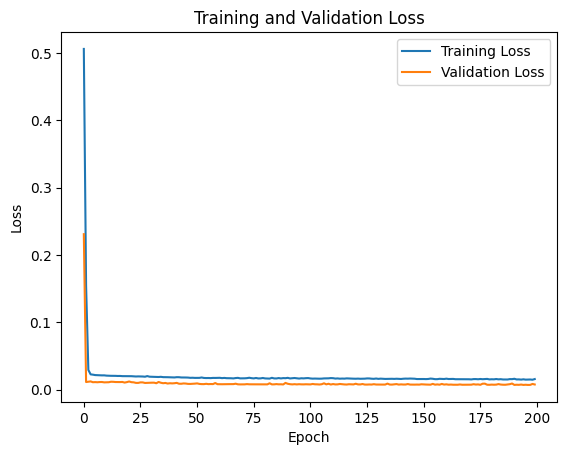

In [84]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for actual and predicted values
fig.add_trace(go.Scatter(x=data.index[train_size:], y=y_test_inv.flatten(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=data.index[train_size:], y=y_pred_inv.flatten(), mode='lines', name='Predicted'))

# Update layout
fig.update_layout(
    title='Actual vs. Predicted Quantity',
    xaxis_title='Time',
    yaxis_title='Quantity',
    width=1000,  # Adjust the width as needed
    height=500,  # Adjust the height as needed
)

# Show the plot
fig.show()

6/6 [==============================] - 0s 7ms/step


In [87]:
# Get the last sequence from the data
last_sequence = quantity_data_scaled[-sequence_length:]

# Reshape the last sequence to match the input shape of the model
last_sequence = last_sequence.reshape((1, sequence_length, 1))

# Make predictions for the next 30 days
future_predictions = []
for _ in range(30):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred

# Inverse transform the future predictions
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 19ms/step


<ipython-input-87-eecbe3a35bea>:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 [==============================] - 0s 19ms/step


In [88]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'data' is already loaded with the dataframe

# Get the last date in the dataset
last_date = data1['DATE'].iloc[-1]

# Create dates for the future predictions
future_dates = pd.date_range(start=last_date, periods=31)[1:]

# Plot historical data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['DATE'], y=data1['Quantity'], mode='lines', name='Historical Data'))

# Add future predictions
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv.flatten(), mode='lines', name='Future Predictions'))

# Update layout
fig.update_layout(
    title='Future Forecast for the Next 30 Days',
    xaxis_title='Date',
    yaxis_title='Quantity'
)

# Show the plot
fig.show()

In [89]:
# Get the last date in the dataset
last_date = data['DATE'].iloc[-1]

# Create dates for the future predictions
future_dates = pd.date_range(start=last_date, periods=31)[1:]

# Create the figure
fig = go.Figure()

# Add trace for future predictions
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions_inv.flatten(), mode='lines', name='Future Predictions'))

# Update layout
fig.update_layout(
    title='Future Forecast for the Next 30 Days',
    xaxis_title='Date',
    yaxis_title='Quantity',
    width=1000,  # Adjust the width as needed
    height=500,  # Adjust the height as needed
)

# Show the plot
fig.show()
